## QOSF Screening Task 1

### Problem statement
The Swap test is a simple quantum circuit which, given two states, allows to compute how much do they differ from each other.
<ol>
<li> Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.</li>
<li>Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.</li>
<li>Suppose you are given with a random state, made by N qubits, for which you only know that it is a product state and each of the qubits are in the state | 0 > or | 1>. By product state we mean that it can be written as the product of single qubit states, without the need to do any summation. For example, the state
|a> = |01>
Is a product state, while the state
|b> = |00> + |11>
Is not.
    </li>
<li> Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.</li>
</ol>

### Solutions

The most general paramterized state for a single qubit is the arbitrary one-qubit gate, the U3 gate.
$$ \begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\\begin{split}U(\theta, \phi, \lambda) =
    \begin{pmatrix}
        \cos(\th)          & -e^{i\lambda}\sin(\th) \\
        e^{i\phi}\sin(\th) & e^{i(\phi+\lambda)}\cos(\th)
    \end{pmatrix}\end{split}\end{aligned}\end{align} $$
    where $0\leq \phi<2\pi$ <br>
    The generality of this gate can be demonstrated by 
    $$ U\left(\theta, -\frac{\pi}{2}, \frac{\pi}{2}\right) = RX(\theta) $$<br>
    $$U(\theta, 0, 0) = RY(\theta) $$
    
   Since a rotation on the x-axis, represented by the Rx preserves only the x cordinate and Ry preserves the y cordinate, The product of these two, which can also re represented on the U gate, can cover all possible points on the bloch sphere

In [1]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from scipy.optimize import minimize

In [2]:
from qiskit.circuit import Parameter
from qiskit.visualization import plot_bloch_vector,plot_bloch_multivector,visualize_transition

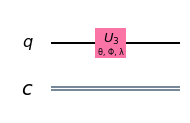

In [3]:
#setting up a simple parametrized quantum circuit
qc=QuantumCircuit(1,1)
theta,phi,lamda=Parameter('θ'),Parameter('Φ'),Parameter('λ')
qc.u3(theta,phi,lamda,0)
qc.draw('mpl')

In [4]:
#initialising the parameters in a random manner
theta_val,phi_val,lamda_val=np.random.random()*2*np.pi,np.random.random()*2*np.pi,np.random.random()*2*np.pi
#numpy.random.random() initilizes a random variable in the range [0,1). It is then scaled to the range[0,2 pi]

qc=qc.bind_parameters({theta: theta_val,phi:phi_val,lamda:lamda_val})

In [5]:
backend = BasicAer.get_backend('statevector_simulator') 
result = execute(qc, backend).result()
psi  = result.get_statevector(qc)

[0.75287931+0.j         0.22901555+0.61702886j]


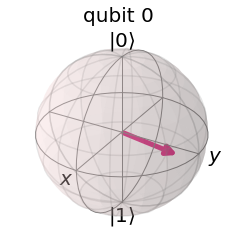

In [6]:
print(psi)
plot_bloch_multivector(psi)

Encapsulating the above cells for further use:

In [7]:
def random_u3_ansatz(name):
    """Returns a parametrised single qubit u3 ansatz with random paramters"""
    
    qc=QuantumCircuit(1,name=name)
    theta,phi,lamda=Parameter('θ'),Parameter('Φ'),Parameter('λ')
    qc.u3(theta,phi,lamda,0)
    theta_val,phi_val,lamda_val=np.random.random()*2*np.pi,np.random.random()*2*np.pi,np.random.random()*2*np.pi
    qc=qc.bind_parameters({theta: theta_val,phi:phi_val,lamda:lamda_val})
    return qc

In [10]:
#Demonstrating expressivity of u3
qr = QuantumRegister(5, 'q')
trial_circuit=QuantumCircuit(qr)
for i in range(5):
    trial_circuit.append(random_u3_ansatz("par u3 "+str(i)),[qr[i]])
trial_circuit.draw()

┌──────────┐
q_0: ┤ par u3 0 ├
     ├──────────┤
q_1: ┤ par u3 1 ├
     ├──────────┤
q_2: ┤ par u3 2 ├
     ├──────────┤
q_3: ┤ par u3 3 ├
     ├──────────┤
q_4: ┤ par u3 4 ├
     └──────────┘

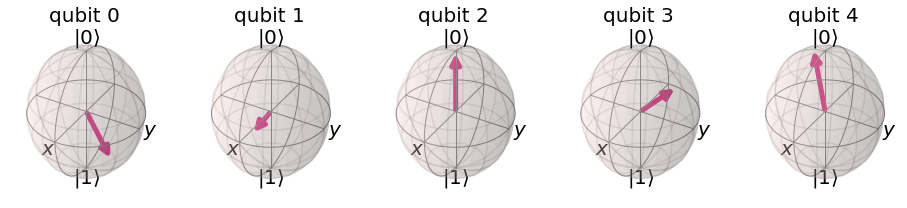

In [11]:
backend = BasicAer.get_backend('statevector_simulator') 
result = execute(trial_circuit, backend).result()
psi  = result.get_statevector(trial_circuit)
plot_bloch_multivector(psi)

#### Swap test and measuring similarity


The swap test provides a measure of similarity between two states. Our aim in this case is to reconstruct the given state using the paramterised circuit, so we seek to maximise the similarity.

In [41]:
def cost(params):
    params=theta_val,phi_val,lamda_val
    qr=QuantumRegister(3)
    cr=ClassicalRegister(1)
    qc= QuantumCircuit(qr,cr)
    qc.u3(t_theta_val,t_phi_val,t_lamda_val,qr[0]) #These three values of the target qubit have to be set in advance from outsode the scope of this function
    qc.u3(theta,phi,lamda,qr[1])
    qc.h(qr[2])
    qc.cswap(qr[2],qr[1],qr[0])
    qc.h(qr[2])
    qc.measure(qr[2],cr)
    qc=qc.bind_parameters({theta:0,phi:0,lamda:0})
    backend = BasicAer.get_backend('qasm_simulator') 
    result = execute(qc, backend,shots=1000).result()
    similarity=(result.get_counts()['0']/1000)
    cost=-similarity
    #print("siilarity is ",similarity)
    return cost

In [42]:
t_theta_val,t_phi_val,t_lamda_val=np.random.random()*2*np.pi,np.random.random()*2*np.pi,np.random.random()*2*np.pi
print("The actual values are: ",t_theta_val,t_phi_val,t_lamda_val)
params=minimize(cost,[0,0,0],method="COBYLA").x
print(params)

The actual values are:  1.0607066203333202 3.8783568595297737 0.8787064957750857
[-0.04041128  0.05177673  1.09677834]


Now let's plot both our target qubit state and the state of the parametrized qunit after optimization

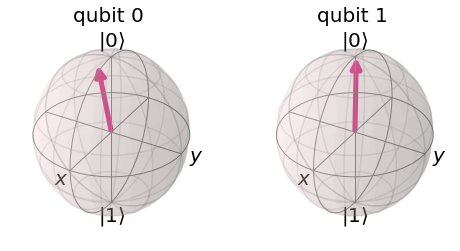

In [43]:
qc=QuantumCircuit(2)
qc.u3(t_theta_val,t_phi_val,t_lamda_val,0)
qc.u3(params[0],params[1],params[2],1)
backend = BasicAer.get_backend('statevector_simulator') 
result = execute(qc, backend).result()
psi  = result.get_statevector(qc)
plot_bloch_multivector(psi)

#### Problem 3

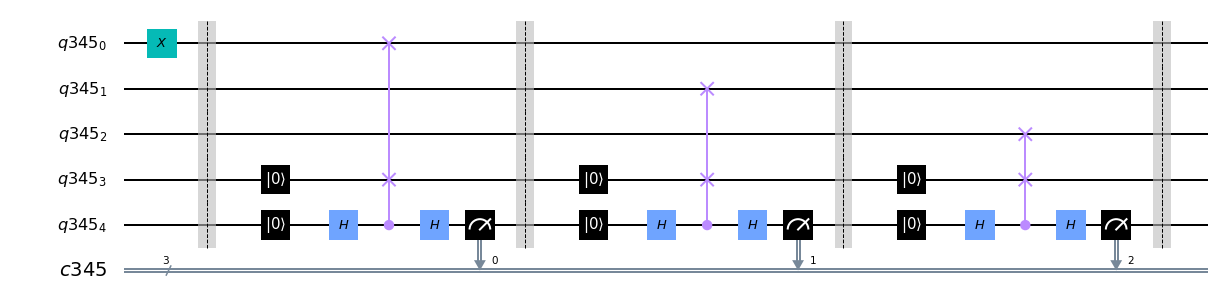

In [58]:
######Enter number of qubits below######
N=3
#######################################
init_vector=[]
for i in range(N):
    init_vector.append(int(np.random.random()>=0.5))
qr=QuantumRegister(N+2)
cr=ClassicalRegister(N)
qc=QuantumCircuit(qr,cr)
for i in range(N):
    if init_vector[i]:
        qc.x(i)
qc.barrier()
###The swap test is applied fofr each of the folowing qubits using the same last two qubits. THe last one is set as the ancilla and the one before it reset at every loop to zero 
for i in range(N):
    qc.reset(N)
    qc.reset(N+1)
    qc.h(N+1)
    qc.cswap(qr[N+1],qr[N],qr[i])
    qc.h(N+1)
    qc.measure(N+1,i)
    qc.barrier()
qc.draw('mpl')

In [59]:
backend = BasicAer.get_backend('qasm_simulator') 
result = execute(qc, backend,shots=100).result()
counts=result.get_counts()

In [60]:
values=counts.keys()
values_int=list(map(lambda x: int(x,2),values))

In [64]:
for i in range((2**N)-1,-1,-1):
    if i in values_int:
        print("the required state is binary equivalent of  ",i)
        break
print("The target is ",init_vector)

the required state is binary equivalent of   1
The target is  [1, 0, 0]


The basic idea here was to use the same ancilla and extra register initialized just to zero to do the swap tests
